In [21]:
#####################################################################################################################
# Authors:  Eddie F. Carrizales
# Date:  10/12/2022
# Description: Neural Network Implementation and Activation Function Analysis
#####################################################################################################################

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
import warnings

url='https://drive.google.com/file/d/1EJg_O6Q_lsnoVMNkFF3wYQtKis873QmJ/view?usp=sharing'
file_id=url.split('/')[-2]
dwn_url='https://drive.google.com/uc?id=' + file_id

In [3]:
original_df = pd.read_csv(dwn_url) # read the file

In [4]:
# Displays our data in rows x columns with the column names (if no column names, then you must manually add column name above)
original_df

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Extent,Perimeter,Class
0,87524,442.246011,253.291155,0.819738,90546,0.758651,1184.040,Kecimen
1,75166,406.690687,243.032436,0.801805,78789,0.684130,1121.786,Kecimen
2,90856,442.267048,266.328318,0.798354,93717,0.637613,1208.575,Kecimen
3,45928,286.540559,208.760042,0.684989,47336,0.699599,844.162,Kecimen
4,79408,352.190770,290.827533,0.564011,81463,0.792772,1073.251,Kecimen
...,...,...,...,...,...,...,...,...
895,83248,430.077308,247.838695,0.817263,85839,0.668793,1129.072,Besni
896,87350,440.735698,259.293149,0.808629,90899,0.636476,1214.252,Besni
897,99657,431.706981,298.837323,0.721684,106264,0.741099,1292.828,Besni
898,93523,476.344094,254.176054,0.845739,97653,0.658798,1258.548,Besni


In [5]:
#-----------------------------Drop Unnecessary Columns and Reorder-------------------------------------
# pre-processing dataset
#   -We removed null entries that did not have complete data
#   -We removed unnecesary columns

# Remove any entries that do not have complete data
df_clean = original_df.dropna(axis = 'rows', how = 'any')

# Remove unnecessary columns or columns with very low correlation
df_clean = df_clean.drop(columns = ['Extent'])

#--------------------------------------Categorical to Numerical----------------------------------------------
# Replacing values
df_clean['Class'].replace(['Kecimen', 'Besni'],
                                  [0, 1], inplace=True)
#--------------------------------------Data Normalization----------------------------------------------
mms = MinMaxScaler()

df_clean_normed = df_clean.copy()

temp = df_clean_normed[["Area",	"MajorAxisLength",	"MinorAxisLength",	"Eccentricity",	"ConvexArea",	"Perimeter",	"Class"]] # just used to visualize better
df_clean_normed[["Area",	"MajorAxisLength",	"MinorAxisLength",	"Eccentricity",	"ConvexArea",	"Perimeter",	"Class"]] = mms.fit_transform(temp)

In [6]:
# Displays our clean normalized dataset
df_clean_normed

,Area,MajorAxisLength,MinorAxisLength,Eccentricity,ConvexArea,Perimeter,Class
0,0.296370,0.280714,0.314376,0.767872,0.255504,0.271791,0.0
1,0.237427,0.234638,0.284945,0.738636,0.208864,0.241842,0.0
2,0.312263,0.280741,0.351778,0.733009,0.268084,0.283594,0.0
3,0.097973,0.078935,0.186620,0.548194,0.084089,0.108284,0.0
4,0.257660,0.164011,0.422064,0.350968,0.219472,0.218493,0.0
...,...,...,...,...,...,...,...
895,0.275975,0.264945,0.298733,0.763836,0.236831,0.245347,1.0
896,0.295540,0.278757,0.331595,0.749761,0.256905,0.286325,1.0
897,0.354240,0.267056,0.445044,0.608017,0.317858,0.324126,1.0
898,0.324983,0.324902,0.316915,0.810259,0.283698,0.307635,1.0


In [7]:
# Next we will use different plots to familiarize with our data and learn how it is distributed
df_clean_normed.dtypes

Area               float64
MajorAxisLength    float64
MinorAxisLength    float64
Eccentricity       float64
ConvexArea         float64
Perimeter          float64
Class              float64
dtype: object

In [8]:
# The thing we are trying to predict is the quality of the wine.
# Using this corr() function, we are able to see the correlation that each of the columns have to
#   the quality of the wine.
# As we can see, there are positive and negative values describing how strongly the correlate with
#   the quality which has a value of 1.0, from this data we want to pick the columns that have an absolute
#   value which is closest to 1.0 (i.e., correlates the strongest)
# Note: In this case they all have somewhat high correlation, thus we will keep all the columns
df_clean_normed.corr()["Class"]

Area               0.625715
MajorAxisLength    0.673194
MinorAxisLength    0.503102
Eccentricity       0.438500
ConvexArea         0.625567
Perimeter          0.665981
Class              1.000000
Name: Class, dtype: float64

**Train_Evaluate**

In [9]:
nrows = len(df_clean_normed.index)
ncols = len(df_clean_normed.columns)
X = df_clean_normed.iloc[:, 0:(ncols - 1)]
y = df_clean_normed.iloc[:, (ncols-1)]
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [10]:
# Below are the hyperparameters that you need to use for model evaluation
activations = ['logistic', 'tanh', 'relu']
learning_rate = [0.01, 0.1]
max_iterations = [100, 200] # also known as epochs
num_hidden_layers = [2, 3]

#-----------------------------Logistic, tanh, and ReLu NN-------------------------------------
labels = [] # used to store plot hyperparameter names
result_table_list = []
mlps = []


for i in range(0, 3): # for activations
  print("------------------------" + activations[i] + "------------------------")
  for j in range(0, 2): # for learning rates
    for k in range(0, 2): # for iterations
      for l in range(0, 2): # for hidden layers
        # Create the neural network and be sure to keep track of the performance
        #   metrics
        mlp = MLPClassifier(activation = activations[i], 
                            learning_rate_init = learning_rate[j], 
                            max_iter = max_iterations[k], 
                            hidden_layer_sizes = num_hidden_layers[l])
        
        #some hyperparameter combinations do not converge so this is used to ignore them
        simplefilter("ignore", category=ConvergenceWarning)

        mlp.fit(X_train, y_train)
        y_test_predict = mlp.predict(X_test)
        y_train_predict = mlp.predict(X_train)
        
        # ---------------------------Weights and Bias Vectors---------------------------
        # Uncomment print statements to view
        # coefs_ is a list of weight matrices, where weight matrix at index i represents the weights between layer i and layer i+1.
        # Below would give the weights between layer 0 and layer 1
        #print(mlp.coefs_[0])
        # intercepts_ is a list of bias vectors, where the vector at index i represents the bias values added to layer i+1.
        # Below would give the bias vectors added to layer 1
        #print(mlp.intercepts_[0])

        # ----------------------Confusion Matrix and Classification Report----------------------
        # Uncomment print statements to view
        #print(confusion_matrix(y_test, y_test_predict))
        #print(classification_report(y_test, y_test_predict, labels=np.unique(y_test_predict)))

        # -----------------------------Create Model Results Table-----------------------------
        # RMSE scores
        rmse_test = (np.sqrt(mean_squared_error(y_test, y_test_predict)))
        rmse_train = (np.sqrt(mean_squared_error(y_train, y_train_predict)))
        # Accuracy Score
        accuracy_test = accuracy_score(y_test, y_test_predict)
        accuracy_train = accuracy_score(y_train, y_train_predict)
        # Combine all the hyperparameters into a string so we can insert into our row
        hyperparameter = str(activations[i]) + " " + str(learning_rate[j]) + " " + str(max_iterations[k]) + " " + str(num_hidden_layers[l])
        # Create a dict of data that we will put into our row
        new_row = {"Model Hyperparameters":hyperparameter, "Train Accuracy":accuracy_train, "Test Accuracy":accuracy_test, "Train Error":rmse_train, "Test Error":rmse_test}
        
        # Appends the row of data to our list which we will use to create the results table
        result_table_list.append(new_row)
        
        # ------Save data/information to use for the Plot-----
        mlps.append(mlp) #append mlp so that we can use this list to create the plots
        labels.append(hyperparameter)

  # ---------Actual and Predicted Values--------
  # Will only print 3 times (one for Logistic, one for tanh, one for ReLu)
  predictions_df = pd.DataFrame()
  predictions_df['Actual origin'] = y_test
  predictions_df['Predicted origin'] = y_test_predict
  print(predictions_df)

------------------------logistic------------------------
     Actual origin  Predicted origin
527            1.0               1.0
62             0.0               1.0
207            0.0               0.0
667            1.0               1.0
472            1.0               1.0
..             ...               ...
22             0.0               0.0
263            0.0               0.0
736            1.0               1.0
428            0.0               0.0
752            1.0               0.0

[225 rows x 2 columns]
------------------------tanh------------------------
     Actual origin  Predicted origin
527            1.0               1.0
62             0.0               1.0
207            0.0               0.0
667            1.0               1.0
472            1.0               1.0
..             ...               ...
22             0.0               0.0
263            0.0               0.0
736            1.0               1.0
428            0.0               0.0
752            

In [11]:
# Add the results table list(all the rows we collected) to the results df and print the results_df
results_table_df = pd.DataFrame(result_table_list)
results_table_df

,Model Hyperparameters,Train Accuracy,Test Accuracy,Train Error,Test Error
0,logistic 0.01 100 2,0.859259,0.822222,0.375154,0.421637
1,logistic 0.01 100 3,0.862222,0.813333,0.371184,0.432049
2,logistic 0.01 200 2,0.874074,0.844444,0.354860,0.394405
3,logistic 0.01 200 3,0.871111,0.840000,0.359011,0.400000
4,logistic 0.1 100 2,0.872593,0.835556,0.356942,0.405518
5,logistic 0.1 100 3,0.875556,0.835556,0.352767,0.405518
6,logistic 0.1 200 2,0.871111,0.844444,0.359011,0.394405
7,logistic 0.1 200 3,0.872593,0.844444,0.356942,0.394405
8,tanh 0.01 100 2,0.865185,0.826667,0.367171,0.416333
9,tanh 0.01 100 3,0.869630,0.835556,0.361068,0.405518


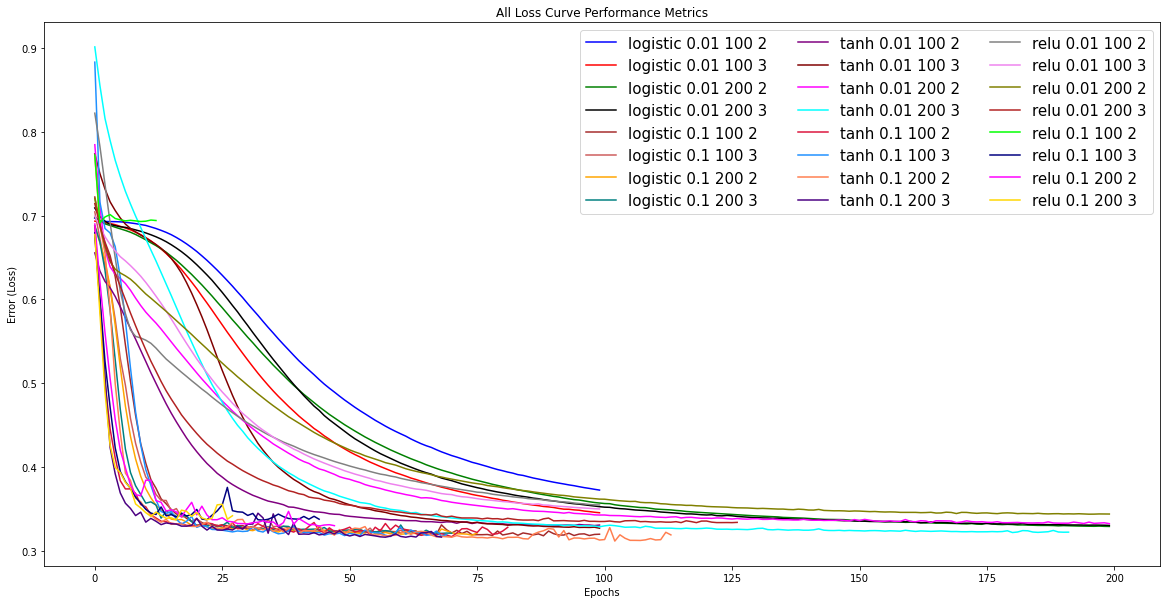

In [14]:
# -----------------------------Create Plot-----------------------------
# Plots the model history for each model in a single plot
# The model history used is a plot of loss vs number of epochs 
# (professor stated we could implement either loss vs epoch or accuracy vs epoch)

plot_args = []

i = 0
while i < len(labels):
  colors = ["blue", "red", "green", "black", "brown", "indianred", "orange", "teal", "purple", "maroon", "magenta",
            "cyan", "crimson", "dodgerblue", "coral", "indigo", "gray", "violet", "olive", "firebrick", "lime",
            "navy", "fuchsia", "gold"]
  plot_args.append({"c": colors[i], "linestyle": "-"})
  i += 1;

#print(plot_args)

for mlp, label, args in zip(mlps, labels, plot_args):
  plt.plot(mlp.loss_curve_, label=label, **args)
plt.title("All Loss Curve Performance Metrics")
plt.legend(ncol=3, loc="upper right", prop={'size': 15}) # create legend and change legend size
plt.xlabel("Epochs")
plt.ylabel("Error (Loss)")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

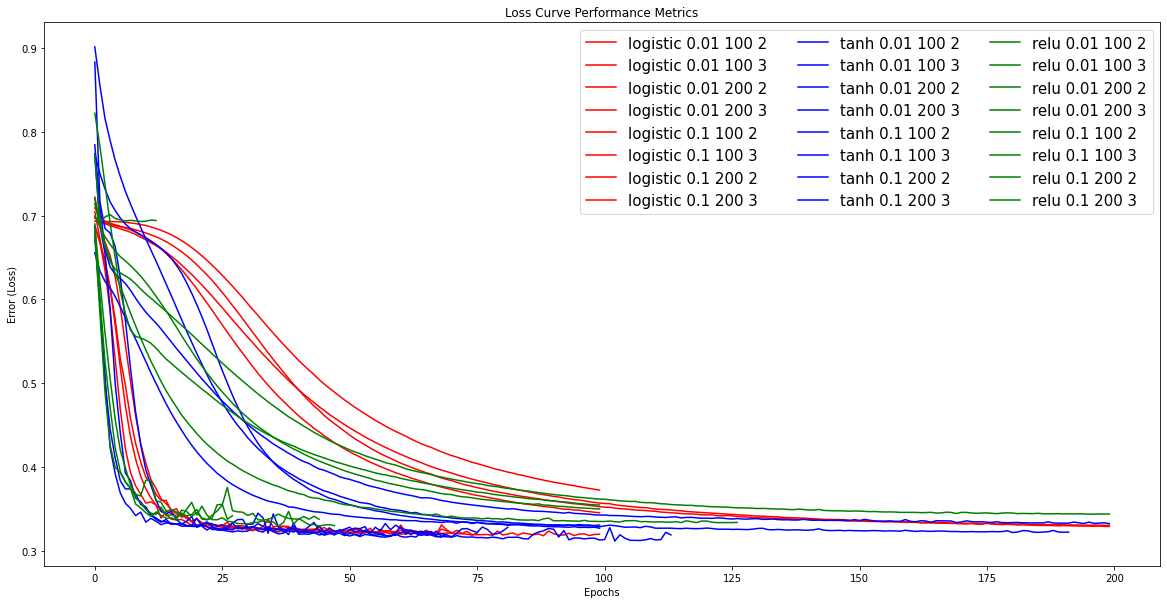

In [15]:
plot_args = []

i = 0
while i < len(labels):
  colors = ["red", "red", "red", "red", "red", "red", "red", "red", "blue", "blue", "blue",
            "blue", "blue", "blue", "blue", "blue", "green", "green", "green", "green", "green",
            "green", "green", "green"]
  plot_args.append({"c": colors[i], "linestyle": "-"})
  i += 1;

#print(plot_args)

for mlp, label, args in zip(mlps, labels, plot_args):
  plt.plot(mlp.loss_curve_, label=label, **args)
plt.title("Loss Curve Performance Metrics")
plt.legend(ncol=3, loc="upper right", prop={'size': 15})
plt.xlabel("Epochs")
plt.ylabel("Error (Loss)")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

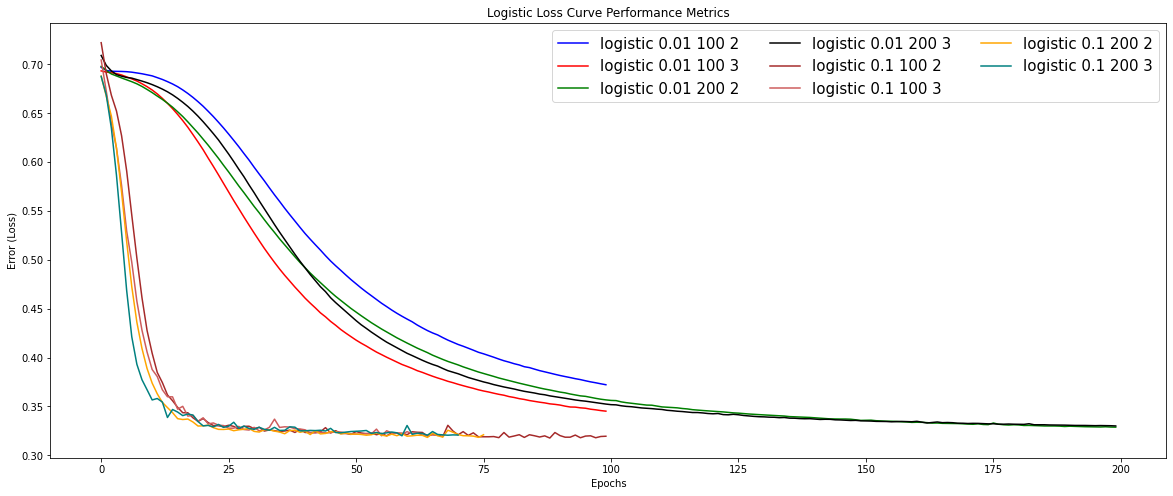

In [17]:
plot_args = []

i = 0
while i < len(labels):
  colors = ["blue", "red", "green", "black", "brown", "indianred", "orange", "teal", "purple", "maroon", "magenta",
            "cyan", "crimson", "dodgerblue", "coral", "indigo", "gray", "violet", "olive", "firebrick", "lime",
            "navy", "fuchsia", "gold"]
  plot_args.append({"c": colors[i], "linestyle": "-"})
  i += 1;

#print(plot_args)
j = 0
for mlp, label, args in zip(mlps, labels, plot_args):
  if  0 <= j < 8:
    plt.plot(mlp.loss_curve_, label=label, **args)
  j += 1

plt.title("Logistic Loss Curve Performance Metrics")
plt.legend(ncol=3, loc="upper right", prop={'size': 15})
plt.xlabel("Epochs")
plt.ylabel("Error (Loss)")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

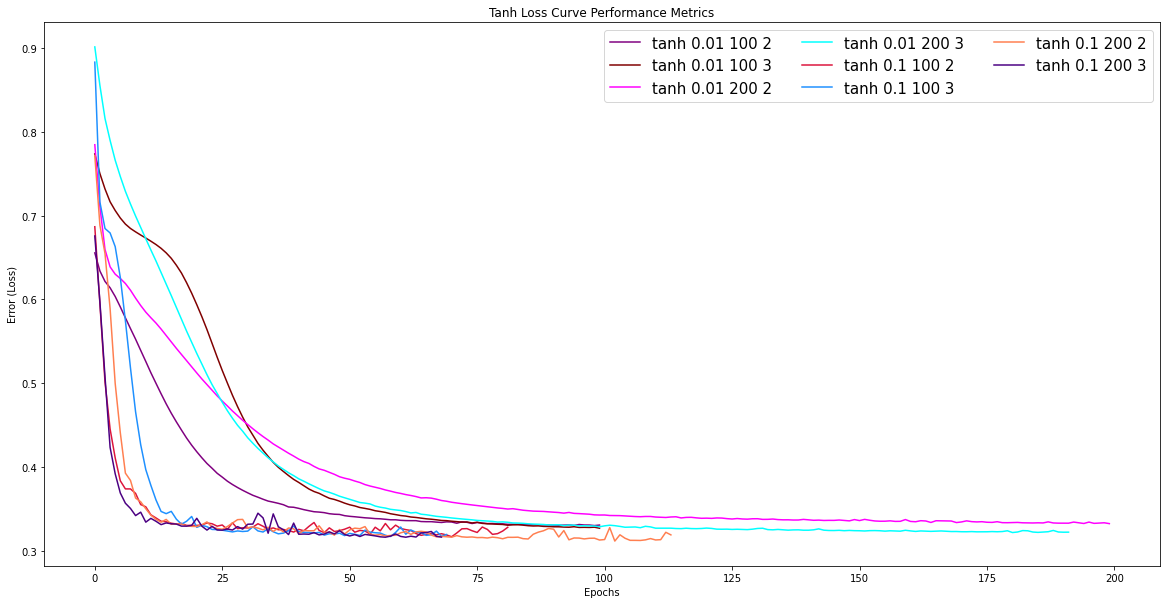

In [18]:
plot_args = []

i = 0
while i < len(labels):
  colors = ["blue", "red", "green", "black", "brown", "indianred", "orange", "teal", "purple", "maroon", "magenta",
            "cyan", "crimson", "dodgerblue", "coral", "indigo", "gray", "violet", "olive", "firebrick", "lime",
            "navy", "fuchsia", "gold"]
  plot_args.append({"c": colors[i], "linestyle": "-"})
  i += 1;

#print(plot_args)
j = 0
for mlp, label, args in zip(mlps, labels, plot_args):
  if  8 <= j < 16:
    plt.plot(mlp.loss_curve_, label=label, **args)
  j += 1

plt.title("Tanh Loss Curve Performance Metrics")
plt.legend(ncol=3, loc="upper right", prop={'size': 15})
plt.xlabel("Epochs")
plt.ylabel("Error (Loss)")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

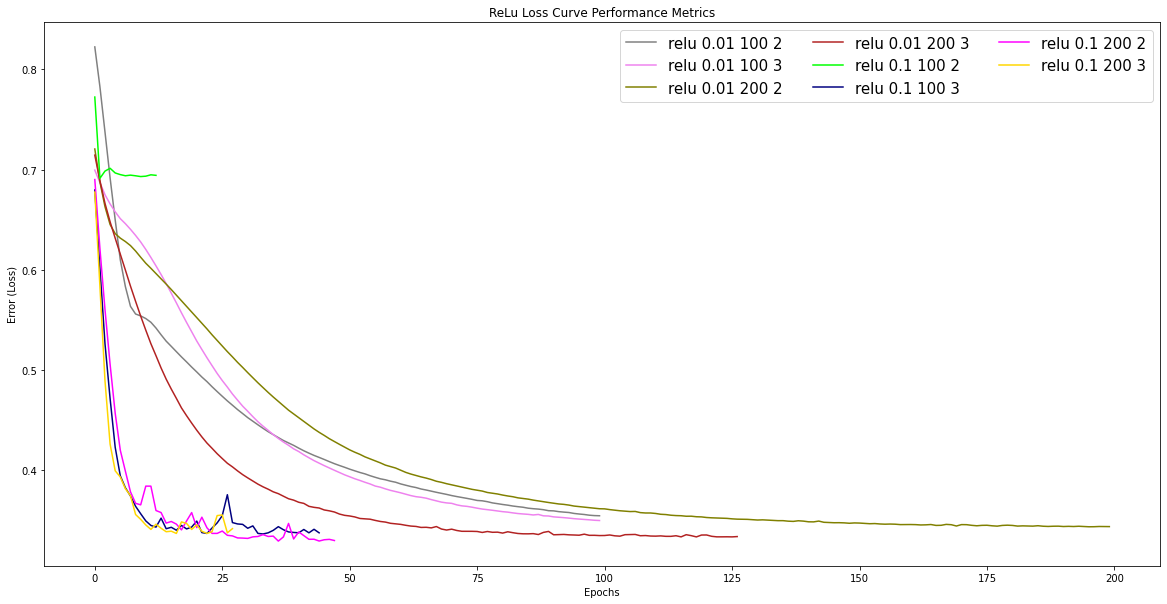

In [19]:
plot_args = []

i = 0
while i < len(labels):
  colors = ["blue", "red", "green", "black", "brown", "indianred", "orange", "teal", "purple", "maroon", "magenta",
            "cyan", "crimson", "dodgerblue", "coral", "indigo", "gray", "violet", "olive", "firebrick", "lime",
            "navy", "fuchsia", "gold"]
  plot_args.append({"c": colors[i], "linestyle": "-"})
  i += 1;

#print(plot_args)
j = 0
for mlp, label, args in zip(mlps, labels, plot_args):
  if  16 <= j < 24:
    plt.plot(mlp.loss_curve_, label=label, **args)
  j += 1

plt.title("ReLu Loss Curve Performance Metrics")
plt.legend(ncol=3, loc="upper right", prop={'size': 15})
plt.xlabel("Epochs")
plt.ylabel("Error (Loss)")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()

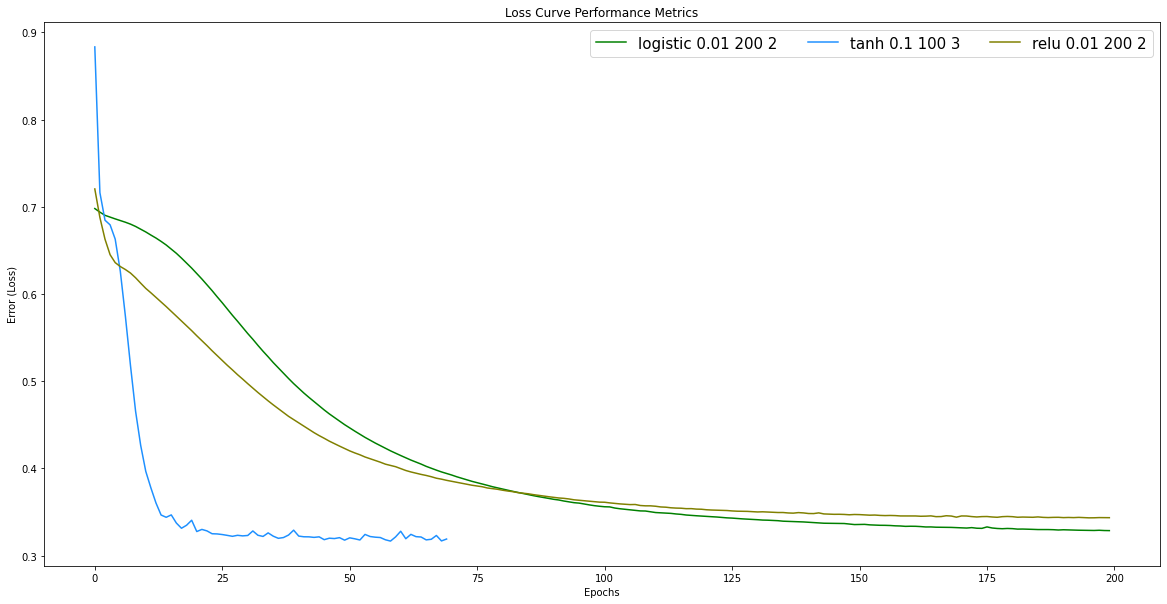

In [20]:
# plots of the best hyperparameters for each on average
plot_args = []

i = 0
while i < len(labels):
  colors = ["blue", "red", "green", "black", "brown", "indianred", "orange", "teal", "purple", "maroon", "magenta",
            "cyan", "crimson", "dodgerblue", "coral", "indigo", "gray", "violet", "olive", "firebrick", "lime",
            "navy", "fuchsia", "gold"]
  plot_args.append({"c": colors[i], "linestyle": "-"})
  i += 1;

#print(plot_args)
j = 0
for mlp, label, args in zip(mlps, labels, plot_args):
  if  j == 2 or j == 13 or j == 18:
    plt.plot(mlp.loss_curve_, label=label, **args)
  j += 1

plt.title("Loss Curve Performance Metrics")
plt.legend(ncol=3, loc="upper right", prop={'size': 15})
plt.xlabel("Epochs")
plt.ylabel("Error (Loss)")
plt.rcParams["figure.figsize"] = (20,10)
plt.show()